In [1]:
import numpy as np
import pandas as pd
import tensorly as tl
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

#from soft_impute import SoftImpute
from fancyimpute import SoftImpute,KNN
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

In [2]:
mumbai = '../data/mumbai-hexclusters-2019-4-All-HourlyAggregate.csv'
bengaluru = '../data/bangalore-wards-2019-4-All-HourlyAggregate.csv'
delhi = '../data/new_delhi-wards-2018-4-All-HourlyAggregate.csv'
kolkata = '../data/kolkata-wards-2019-4-All-HourlyAggregate.csv'
hyderabad = '../data/hyderabad-wards-2019-4-All-HourlyAggregate.csv'

In [3]:
bengaluru18Q4 = '../data/bangalore-wards-2018-4-All-HourlyAggregate.csv'
bengaluru19Q3 = '../data/bangalore-wards-2019-3-All-HourlyAggregate.csv'
bengaluru19Q2 = '../data/bangalore-wards-2019-2-All-HourlyAggregate.csv'
bengaluru19Q1 = '../data/bangalore-wards-2019-1-All-HourlyAggregate.csv'
bengaluru20Q1 = '../data/bangalore-wards-2020-1-All-HourlyAggregate.csv'

In [4]:

def fillTensor(tensor,row):
    tensor[row.dstid-1,row.sourceid-1,row.hod] = row.mean_travel_time

def df2tensor(f):
    df = pd.read_csv(f)
    #assert df.sourceid.max()==df.dstid.max()
    _nodes = max(df.dstid.max(),df.sourceid.max())
    _tensor = np.zeros((_nodes,_nodes,24))
    df.pipe(lambda x: fillTensor(_tensor,x))
    #print(nptensor[179,100,11])
    assert (df.mean_travel_time.unique()==0).any()==False
    #df.mean_travel_time[df.sourceid==101][df.dstid==180][df.hod==11]
    return _nodes,_tensor

In [5]:
Q42019tensor,nodes = df2tensor(bengaluru)

In [6]:
def df2matrix(f):
    _nodes,_tensor = df2tensor(f) 
    _matrix = np.zeros((_nodes*_nodes,24))
    for i in range(24):
        _matrix[:,i] = _tensor[:,:,i].flatten()
        
    return _nodes,_matrix

In [7]:
nodes,npmatrix = df2matrix(bengaluru)

npmatrix_copy = npmatrix.copy()
npmatrix[npmatrix==0]=np.nan

In [8]:
npmatrix_imputed = SoftImpute().fit_transform(npmatrix)

[SoftImpute] Max Singular Value of X_init = 2211848.921989
[SoftImpute] Iter 1: observed MAE=93.848264 rank=24
[SoftImpute] Iter 2: observed MAE=104.905721 rank=21
[SoftImpute] Iter 3: observed MAE=109.739462 rank=12
[SoftImpute] Iter 4: observed MAE=109.717647 rank=8
[SoftImpute] Iter 5: observed MAE=110.140805 rank=6
[SoftImpute] Iter 6: observed MAE=109.690136 rank=6
[SoftImpute] Iter 7: observed MAE=109.553868 rank=6
[SoftImpute] Iter 8: observed MAE=109.551227 rank=6
[SoftImpute] Iter 9: observed MAE=109.688863 rank=6
[SoftImpute] Iter 10: observed MAE=109.956739 rank=6
[SoftImpute] Iter 11: observed MAE=110.262462 rank=6
[SoftImpute] Iter 12: observed MAE=110.298191 rank=5
[SoftImpute] Iter 13: observed MAE=110.222967 rank=5
[SoftImpute] Iter 14: observed MAE=110.174307 rank=5
[SoftImpute] Iter 15: observed MAE=110.150204 rank=5
[SoftImpute] Iter 16: observed MAE=110.139333 rank=5
[SoftImpute] Iter 17: observed MAE=110.135335 rank=5
[SoftImpute] Iter 18: observed MAE=110.134788 r

In [9]:
def rank2svd(k):
    _svd=TruncatedSVD(n_components=k,n_iter=100)
    _svd.fit(npmatrix_imputed)
    return _svd

In [10]:
allsvds=list(map(rank2svd,range(1,20)))



In [11]:
explained = list(map(lambda x: x.explained_variance_ratio_.sum(), allsvds))

Text(0.5, 1.0, 'Rank vs ExplainedVariance')

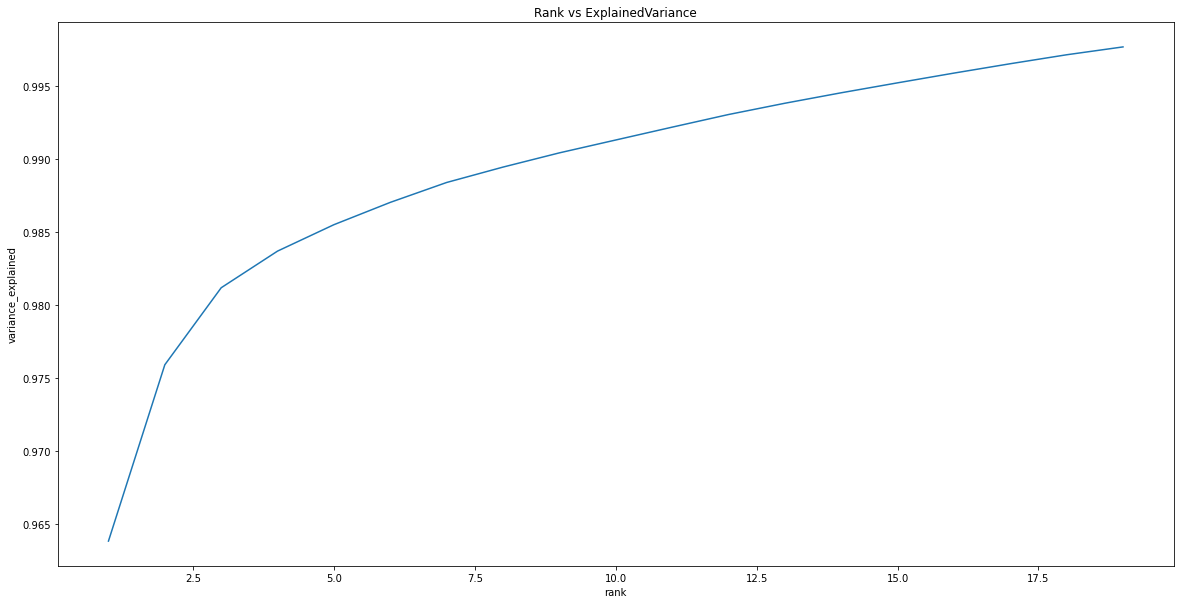

In [12]:
ax=sns.lineplot(x=range(1,len(explained)+1),y=explained)
ax.set(xlabel='rank',ylabel='variance_explained')
plt.title('Rank vs ExplainedVariance')

Text(0.5, 1.0, 'Rank vs SqrtUnexplainedVariance')

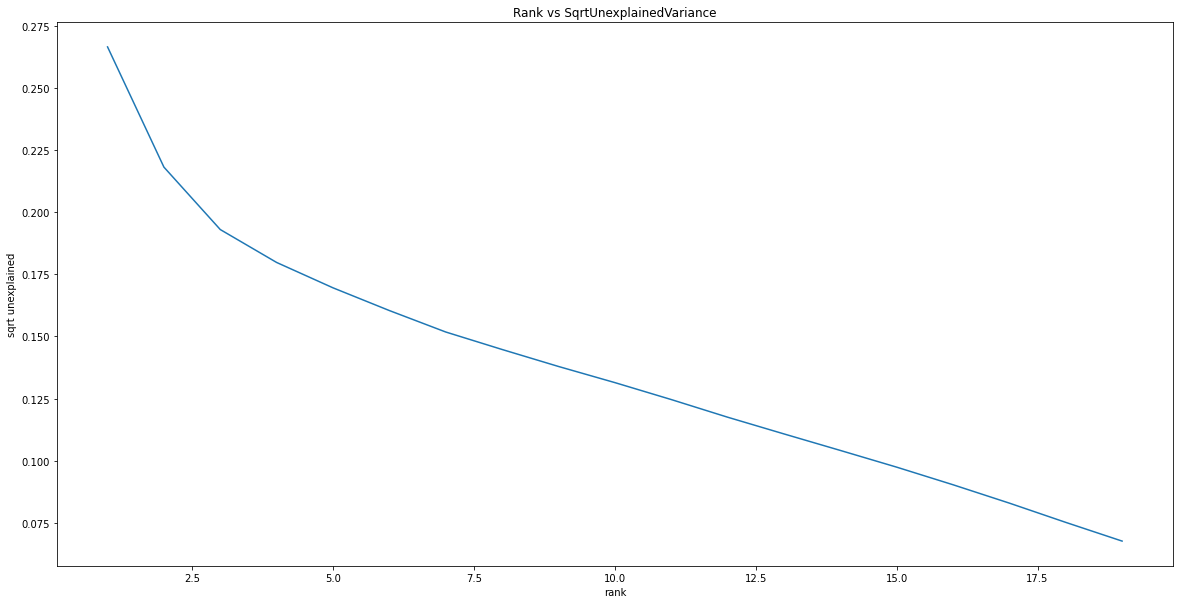

In [13]:
ax=sns.lineplot(x=range(1,len(explained)+1), y=list(map(lambda x:np.sqrt(1-x**2),explained))  )
ax.set(xlabel='rank',ylabel='sqrt unexplained')
plt.title('Rank vs SqrtUnexplainedVariance')

In [14]:
def unexplainedQXvsQY(QXmatrix,QYmatrix,useonlymaskQX=False):
    maskQX = QXmatrix != 0
    maskQY = QYmatrix != 0
    #print(maskQX)
    if useonlymaskQX:
        mask = maskQX
    else:
        mask = maskQX * maskQY
        
    err = np.linalg.norm ( (QXmatrix - QYmatrix)*mask  )
    rel_err = err **2 / np.linalg.norm(QXmatrix*mask)**2
    
    return rel_err

In [15]:
def QXvsReconstructedQY(rank):
    _u, _s, _vt = svds(npmatrix_imputed, k=rank)
    ymatrix = _u @ np.diag(_s) @ _vt
    
    errors = []
    for x in [bengaluru18Q4,bengaluru19Q1, bengaluru19Q2, bengaluru19Q3, bengaluru, bengaluru20Q1]:
        xnodes,xmatrix = df2matrix(x)
        e=unexplainedQXvsQY(xmatrix,ymatrix)
        errors.append(e)
        
    return errors

In [16]:
direct_errors=[]
for x in [bengaluru18Q4,bengaluru19Q1, bengaluru19Q2, bengaluru19Q3, bengaluru, bengaluru20Q1]:
        xnodes,xmatrix = df2matrix(x)
        ynodes,ymatrix = df2matrix(bengaluru)
        e=unexplainedQXvsQY(xmatrix,ymatrix)
        direct_errors.append(e)

In [17]:
errors = QXvsReconstructedQY(3)
recon_unexplained = pd.DataFrame({'time':['bengaluru18Q4','bengaluru19Q1', 'bengaluru19Q2', 'bengaluru19Q3', 'bengaluru19Q4*', 'bengaluru20Q1'],
            'recon_unexplained': errors,
            'direct_errors': direct_errors
             })

Text(0.5, 1.0, 'Direct and Reconstructed errors over time with 2019Q4 as reference for SVD on imputed matrix')

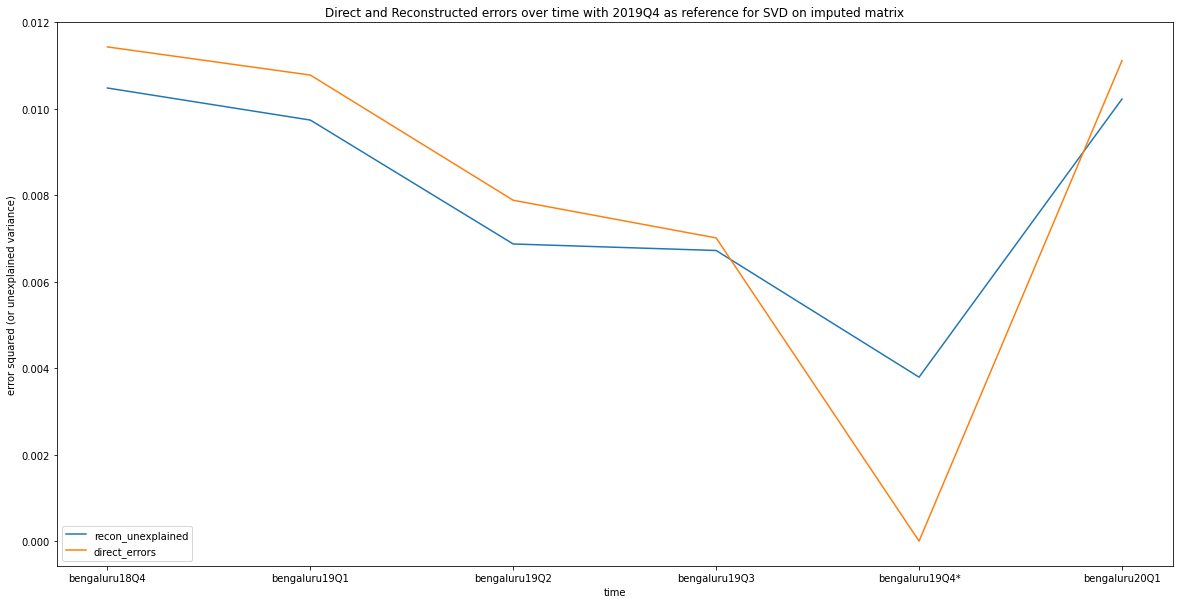

In [18]:
ax=recon_unexplained.plot('time')
ax.set(ylabel='error squared (or unexplained variance)')
plt.title('Direct and Reconstructed errors over time with 2019Q4 as reference for SVD on imputed matrix')